# Wine Quality Prediction Machine Learning Model
## Introduction to Machine Learning: Supervised Learning Final Project
## By: Kevin Boyle (MS-DS)

### Project Topic 

Hello! In my final project, I am going to read in a dataset of red wines. I got this red wine dataset from the following website: https://archive.ics.uci.edu/dataset/186/wine+quality

The data set contain 11 feature columns:
1. Fixed Acidity
2. Volatile Acidity
3. Citric Acid
4. Residual Sugar
5. Chlorides
6. Free Sulfur Dioxide
7. Total Sulfur Dioxide
8. Density
9. pH
10. Sulphates
11. Alcohol

In addition, it contains the column "Quality", with a score from 3 to 8 which determines whether a wine is considered bad (lower score) or good (higher score). 

In my project, I am going to read in this data, and then use a support vector machine (SVM) to best utilize the feature columns to predict quality in wines.

### Data Import, EDA and Cleaning

The first thing I am going to do is import all necessary packages into my notebook. I also included the nonlinear plot function from our week 6 assignment for visualizations in this project.

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
from mlxtend.evaluate import feature_importance_permutation

I am next going to read in the data set.

In [2]:
wine_data = pd.read_csv("winequality-red.csv")

In [3]:
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [4]:
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


By reading in this dataset and seeing the info and head, we can determine that it is fairly clean. There are no null values to remove to change (1599 entries, and 1599 non-null count for each column), but I do see that quality is an integer value determining a score. For the sake of this machine learning model, we will only be predicting if a wine is bad (-1) or good (1), so I will be cleaning up that column.

In [10]:
wine_data['quality'].unique()

array([5, 6, 7, 4, 8, 3])

The quality score is 6 integers, from 3 to 8. For the purposes of this machine learning model, we will say that bad (-1) is the following scores: 3, 4, 5, and 6. A good (1) score is a 7 or 8. I will now reset those values in the dataset.

In [11]:
wine_data = wine_data.replace({'quality': {3: -1, 4: -1, 5: -1, 6: -1, 7: 1, 8: 1}})

In [12]:
wine_data['quality'].unique()

array([-1,  1])

In [13]:
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,-1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,-1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,-1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,-1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,-1


As you can see, now the quality column is a binary value between -1 (bad wine) and 1 (good wine). Using this cleaned data set, I will see if I can predict if a wine is good or bad.

(array([1382.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         217.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

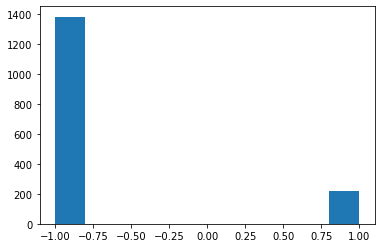

In [14]:
plt.hist(wine_data['quality'])

In this histogram and metadata above, you can see that using this quality classification system of Good being 7 and 8 on the quality scale, there are about 1400 "bad" wines and 200 or so "good" wines in the dataset to work with.

### Model

For this project, I am going to use a support vector machine (SVM) to try to get an accurate prediction of quality of wine. 

To start, I need to split up the data set into training and testing data. I will have the testing data be 25% of the data.

In [15]:
X = wine_data.drop('quality', axis = 1)
y = wine_data['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

Now that I've split the data, I will train the model on the training data set.

In [16]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [17]:
support_vector = SVC().fit(X_train, y_train)

This is a standard SVC with all default values to start to get our baseline. By creating a predict function on the SVC and setting to y_pred, I can see what the accuracy would be.

In [18]:
y_pred = support_vector.predict(X_test)
print("The accuracy score for a default SVC on this wine data set is: " + str(accuracy_score(y_test, y_pred)))

The accuracy score for a default SVC on this wine data set is: 0.8875


The precision for this model as a linear SVC is around 89%. That is good! But...I think we can do better by optimizing our hyperparameters. The next part of our project will be using GridSearchCV to determine which are the optimized parameters to use for this SVC. The parameters I will try are C and gamma between 0.5 and 1.5 (in 0.1 increments), and then kernels methods of "linear" and "rbf".

In [19]:
parameters = {'C': [0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5],
              'kernel':['linear', 'rbf'],
              'gamma':[0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5]}

Now, I will do a Grid Search using those parameters and fitting to the current training dataset.

In [20]:
svc = SVC()
grid = GridSearchCV(svc, param_grid=parameters, cv=10, scoring='accuracy')

In [21]:
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4,
                               1.5],
                         'gamma': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3,
                                   1.4, 1.5],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [22]:
grid.best_params_

{'C': 1.4, 'gamma': 0.7, 'kernel': 'rbf'}

By doing the grid search, I was able to find the optimal parameters for an SVC with this data set. They are C = 1.4, gamma of 0.7, and kernel being rbf. I will now enter those into the SVC model and fit to the training data to determine the new accuracy.

In [23]:
svc2 = SVC(C=1.4, gamma= 0.7, kernel = 'rbf')
svc2.fit(X_train,y_train)
y_pred2 = svc2.predict(X_test)
print("The accuracy score for an SVC with optimized parameters on this wine data set is: " + str(accuracy_score(y_test, y_pred2)))

The accuracy score for an SVC with optimized parameters on this wine data set is: 0.9025


OK! I was able to increase the accuracy to over 90% by tweaking and optimizing the parameters a bit. 

Now, I am going to show which features are most important to this RBF model.

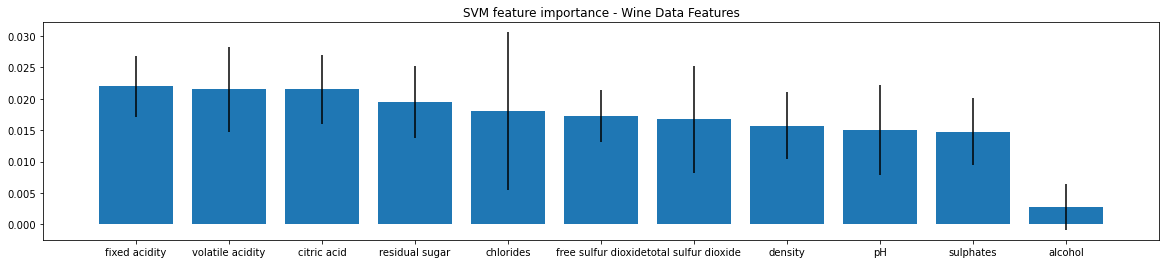

In [24]:
imp_vals, imp_all = feature_importance_permutation(
    predict_method=svc2.predict, 
    X=X_test,
    y=y_test,
    metric='accuracy',
    num_rounds=10,
    seed=1)


std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::-1]

plt.figure().set_figwidth(20)
plt.title("SVM feature importance - Wine Data Features")
plt.bar(range(X.shape[1]), imp_vals[indices],
        yerr=std[indices])
plt.xticks(range(X.shape[1]), X.columns)
plt.xlim([-1, X.shape[1]])
plt.show()

According to this feature importance chart, the main three important features for SVM here are Fixed Acidity, Volatile Acidity, Citric Acid.

I see that alcohol is not important by comparison. One last thing I am going to try is to remove the alcohol column from the dataset and try another SVC this new subset of features. I will follow the same steps as above, but with a dataset without "alcohol" as a column. This is the iterative process of model building.

In [25]:
X2 = X.drop('alcohol', axis = 1)
y2 = wine_data['quality']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.25, random_state = 42)

In [26]:
sc = StandardScaler()
X2_train = sc.fit_transform(X2_train)
X2_test = sc.fit_transform(X2_test)

In [27]:
svc = SVC()
grid = GridSearchCV(svc, param_grid=parameters, cv=10, scoring='accuracy')

In [28]:
grid.fit(X2_train, y2_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4,
                               1.5],
                         'gamma': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3,
                                   1.4, 1.5],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [29]:
grid.best_params_

{'C': 1.5, 'gamma': 1.0, 'kernel': 'rbf'}

In [30]:
svc3 = SVC(C=1.5, gamma= 1.0, kernel = 'rbf')
svc3.fit(X2_train,y2_train)
y_pred3 = svc3.predict(X2_test)
print("The accuracy score for an SVC with optimized parameters on this wine data set is: " + str(accuracy_score(y2_test, y_pred3)))

The accuracy score for an SVC with optimized parameters on this wine data set is: 0.9125


By removing alcohol content datapoint, we optimized even more to 91.25% accuracy! Without overfitting or over-optimizing, I am pretty content with this model and the results.

### Conclusion

Based on this data set and by using a support vector machine, I was able to clean the data, explore the data, optimize the model using GridSearch, and then continue iterating by removing further columns and lesser importance. By doing so, I was able to achieve a machine learning model with an accuracy score of over 91% accuracy. 

Ways I could continue to improve the model is to maybe consider some of the other supervised learning models we covered in class, such as a random forest, and then laying the SVM on top of the random forest of features.

Overall, I had a great time working on this project. Thank you for reading!